# Gait Analysis
**Progetto FESI 2021/2022 - Brocchi Martina (S4803890)**

## Introduzione
In questo notebook analizziamo serie temporali derivate dall'evoluzione della posizione di 4 punti anatomici (anca, ginocchio, caviglia, piede) di persone sane e pazienti con deficit neuromotori.
In particolare ad ogni punto anatomico sono associate le coordinate x e y sul piano immagine. 

<img src="Phases-of-the-normal-gait-cycle.png">

## Obiettivi
* Ricostruire tramite animazioni andamento di serie temporali
* Approfondire tecniche di rimozione del rumore tramite utilizzo di filtri e convoluzione
* Analizzare la derivata del segnale, calcolata tramite differenze finite
* Individuare picchi e valli del segnale al fine di stabilire lunghezza e tempo dei passi
* Confrontare statistiche del passo di pazienti e persone sane

## Metodi e algoritmi

Iniziamo mettendo a confronto l'andamento della gamba destra di una persona sana e di una persona malata.
Innanzitutto importiamo le librerie necessarie.

In [1]:
import os
import pandas as pd

import numpy as np

import matplotlib.animation as animation
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter,filtfilt, lfilter, find_peaks
from scipy.ndimage import convolve1d

from sympy import *

Importiamo i dati della gamba destra dei pazienti e delle persone sane

In [2]:
def loadData(data_, dirName):
    data = []

    for file in os.listdir(dirName):
        data.append(loadmat(dirName+file)) 

    print("\nLista",dirName)
    i = 0
    for person in data:
        print(i,'- ',list(person.keys())[3])
        data_.append(person[list(person.keys())[3]])
        i+=1
    
    return data_

In [3]:
data_people = loadData([],'Sani/dx/')
data_patients = loadData([], 'Pazienti/dx/')


Lista Sani/dx/
0 -  S002_dx
1 -  S004_dx
2 -  S009_dx
3 -  S001_dx
4 -  S005_dx

Lista Pazienti/dx/
0 -  S_241_01_R
1 -  S_753_01_R
2 -  S_522_01_R
3 -  S_211_01_R
4 -  S_241_02_R
5 -  S_468_03_R


Selezioniamo ora un individuo per tipologia, di cui andremo ad analizzare i dati più nel dettaglio

In [4]:
data_person = data_people[0]
data_patient = data_patients[0]

In [5]:
print('Struttura dati persona sana: ',data_person.shape)
print('Struttura dati paziente: ',data_patient.shape)

Struttura dati persona sana:  (95, 8)
Struttura dati paziente:  (287, 8)


Come accennato in precedenza ogni persona possiede 8 serie temporali, ognuna delle quali è associata alle coordinate x o y dei 4 punti anatomici.

### Andamento delle serie temporali

Attraverso la funzione FuncAnimation della libreria matplotlib.animation andiamo a visualizzare un'animazione della camminata dei due individui, grazie alle coordinate x e y dei punti anatomici della gamba.

<IPython.core.display.Javascript object>


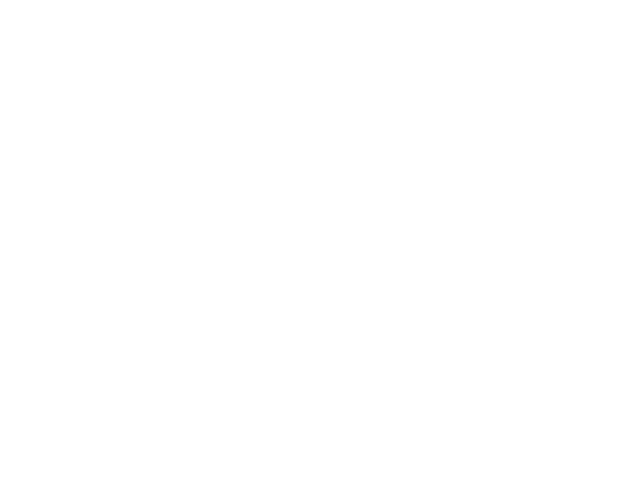

In [6]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(xlim =(np.nanmin(data_person[:,::2])-50, np.nanmax(data_person[:,::2])+50),ylim =(np.nanmin(data_person[:,1::2])-50,np.nanmax(data_person[:,1::2])+50))
line, = ax.plot([],[], lw=2)
plt.gca().invert_yaxis()

def init():
    line.set_data([],[])
    return line

def animate_person(i):
    x = data_person[i, ::2]
    y = data_person[i, 1::2]
    plt.scatter(x,y)
    line.set_data(x,y)
    return line

a = animation.FuncAnimation(fig, animate_person, init_func=init, frames=data_person.shape[0], interval=100)
plt.show()

<IPython.core.display.Javascript object>


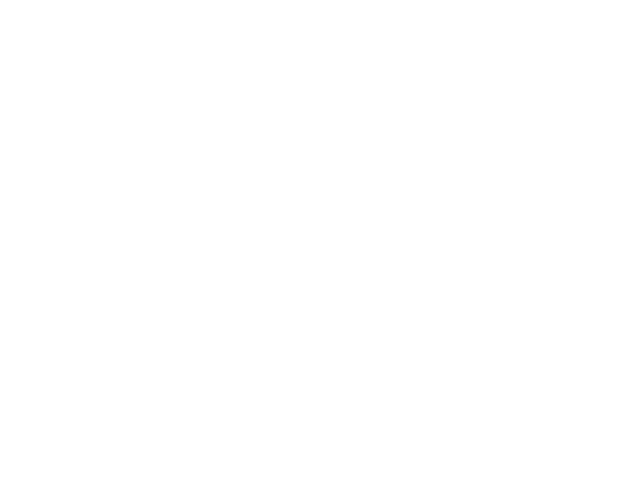

/home/martina/.local/lib/python3.10/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [7]:
fig = plt.figure()
ax = plt.axes(xlim =(np.nanmin(data_patient[:,::2])-50, np.nanmax(data_patient[:,::2])+50),ylim =(np.nanmin(data_patient[:,1::2])-50,np.nanmax(data_patient[:,1::2])+50))
line, = ax.plot([],[], lw=2)
plt.gca().invert_yaxis()

def animate_patient(i):
    x = data_patient[i, ::2]
    y = data_patient[i, 1::2]
    plt.scatter(x,y)
    line.set_data(x,y)
    return line

a = animation.FuncAnimation(fig, animate_patient, init_func=init, frames=data_patient.shape[0], interval=100)
plt.show()

Analizziamo in particolare il piede dei due individui. Il grafico che descrive lo spostamento del piede nello spazio è il seguente

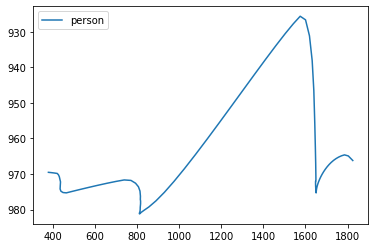

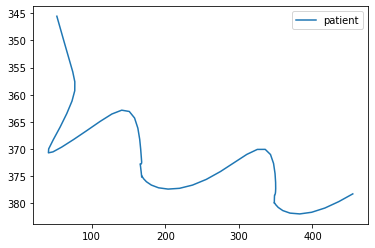

In [8]:
%matplotlib inline

plt.figure()
plt.plot(data_person[:,6], data_person[:,7])
plt.legend(["person"])
plt.gca().invert_yaxis()
plt.show()

plt.figure()
plt.plot(data_patient[:,6], data_patient[:,7])
plt.legend(["patient"])
plt.gca().invert_yaxis()
plt.show()

Il grafico del paziente ha un andamento particolare, probabilmente dovuto al fatto che il movimento della gamba non fosse parallelo alla telecamera bensì obliquo.
Andiamo ora ad analizzare il grafico in funzione del tempo (frame) delle serie temporali riguardanti il movimento lungo l'asse x del piede.

In [9]:
def plot(data, serie, legend, ylabel):
    plt.figure()
    plt.plot(data[:,serie])
    plt.legend([legend])
    plt.xlabel('frame')
    plt.ylabel(ylabel)
    plt.show()

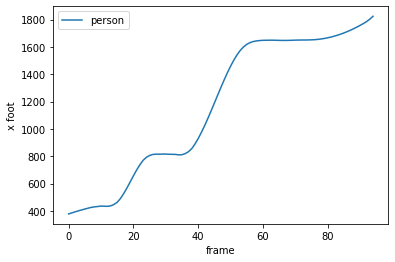

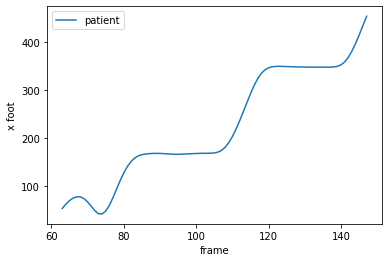

In [10]:
serie = 6
plot(data_person, serie, 'person', 'x foot')
plot(data_patient, serie, 'patient', 'x foot')

In [11]:
print (np.where(np.isnan(data_patient[:,serie])))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
       202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214,
       215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227,
       228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 2

La serie temporale delle ascisse del paziente contiene dei valori nulli (nan) all'inizio e alla fine, ma non in posizioni centrali. Al fine dell'analisi del segnale tali valori possono essere scartati.

In [12]:
min = 63
max = 147

### Rumore e filtri
Andiamo a rappresentare il segnale di paziente e soggetto sano nelle frequenze tramite la trasformata di Fourier.

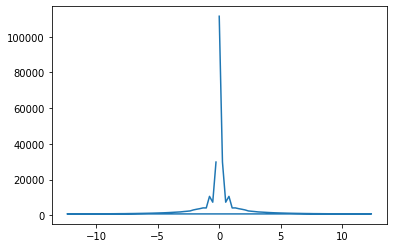

In [13]:
fs = 25 #frequenza campionamento video - frame al secondo (fps)
fft_person = np.fft.fft(data_person[:,serie])
n1 = len(fft_person) #numero di frame
freq = np.fft.fftfreq(n1, 1/fs) #frequenze campionate da trasformata fourier

plt.plot(freq,np.abs(fft_person))
plt.show()

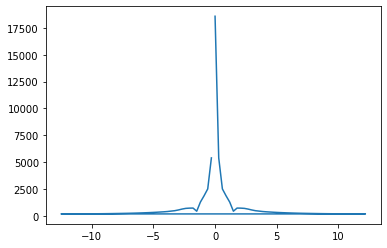

In [14]:
fft_patient = np.fft.fft(data_patient[min:max, serie])
n2 = len(fft_patient) #numero di frame
freq = np.fft.fftfreq(n2, 1/fs) 

plt.plot(freq,np.abs(fft_patient))  
plt.show()

Come possiamo osservare in entrambi i casi il segnale è pulito: non è possibile rilevare la camminata umana con una frequenza maggiore di 12Hz, ma tutte le frequenze dei segnali sono ampiamente sotto tale soglia. Possiamo quindi concludere che non sia presente del rumore e che quindi non sia necessario applicare un filtro passa basso.

Per approfondire l'uso dei filtri andiamo ad aggiungere un rumore casuale al segnale del paziente, che cercheremo successivamente di eliminare. 

Per prima cosa trasformiamo nuovamente il segnale tramite la trasformata inversa di Fourier, dopodiché applichiamo al segnale un rumore da noi creato.

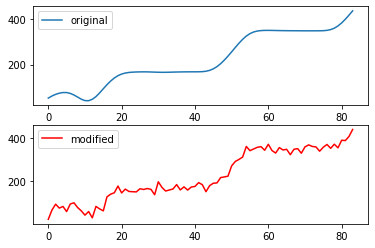

In [15]:
f_patient = np.fft.ifft(fft_patient)

f_patient +=  np.random.uniform(10,30)*np.cos(2 * np.pi * f_patient) + np.random.uniform(0,20)* np.cos(10 * 4 * np.pi * f_patient) + np.random.uniform(0, 20)* np.cos(3 * 2 * np.pi * f_patient)

plt.subplot(211)
plt.plot(data_patient[min:max, serie])
plt.legend(['original'])

plt.subplot(212)
plt.plot(np.real(f_patient),'r')
plt.legend(['modified'])
plt.show() 

Applichiamo ora un'operazione di convoluzione con una gaussiana per cercare di eliminare il rumore presente nel segnale.

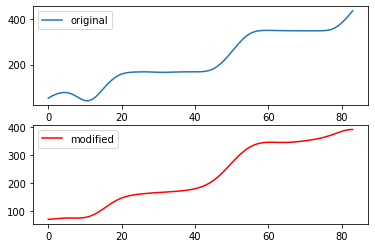

In [16]:
windowg = signal.windows.gaussian(f_patient.shape[0], std=4) #std = deviazione standard (più alta più filtri)
windowg /= sum(windowg)
filt=convolve1d(f_patient,windowg) 

plt.subplot(211)
plt.plot(data_patient[min:max, serie])
plt.legend(['original'])

plt.subplot(212)
plt.plot(np.real(filt),'r')
plt.legend(['modified'])
plt.show() 

Andando a convolvere nel tempo riusciamo ad eliminare il rumore inserito in precedenza, ottenendo un segnale simile a quello originario

## Analisi sperimentale

Consideriamo ora la gamba sinistra degli individui

In [17]:
data_people = loadData([],'Sani/sx/')
data_patients = loadData([], 'Pazienti/sx/')

data_person = data_people[1]
data_patient = data_patients[2]


Lista Sani/sx/
0 -  S001_sx
1 -  S005_sx
2 -  S002_sx
3 -  S004_sx
4 -  S009_sx

Lista Pazienti/sx/
0 -  S_522_01_L
1 -  S_468_02_L
2 -  S_802_01_L
3 -  S_468_01_L
4 -  S_241_02_L
5 -  S_211_01_L
6 -  S_241_01_L


In [18]:
print('Struttura dati persona sana: ',data_person.shape)
print('Struttura dati paziente: ',data_patient.shape)

Struttura dati persona sana:  (101, 8)
Struttura dati paziente:  (488, 8)


(101, 8)
(488, 8)


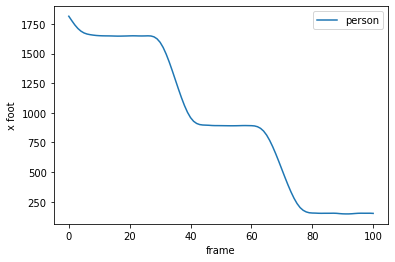

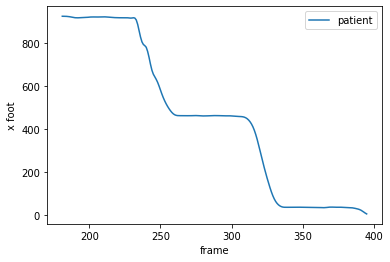

In [19]:
serie = 6
print(data_person.shape)
print(data_patient.shape)
plot(data_person, serie, 'person', 'x foot')
plot(data_patient, serie, 'patient', 'x foot')

Anche in questo caso il segnale del paziente presenta dei valori nulli, che andiamo a rimuovere con il seguente criterio:
* Se i valori nulli sono all'interno della serie, utilizziamo la funzione interpolate della libreria pandas
* Se i valori nulli sono al limite della serie andiamo a scartarli

In [20]:
def removeNan(data):
    f_patient = np.array(pd.Series(data).interpolate(method='polynomial', order=5, limit_area='inside'))
    return f_patient[~np.isnan(f_patient)]

In [21]:
f_patient = removeNan(data_patient[:,serie])

Siccome sappiamo che le derivate sono molto sensibili al rumore, prima di proseguire con l'analisi dei segnali andiamo ad applicare un filtro mediano. Il principio di funzionamento di questo filtro è di lavorare su un singolo campione per volta, andandolo a sostituire con il valore mediano dei suoi vicini (valori a destra e alla sinistra del campione, racchiusi in una certa finestra).

In particolare andiamo ad applicare al segnale prima un filtro mediano, e sul risultato di questo filtraggio andiamo ad applicare un filtro passa basso (convoluzione con gaussiana).

In [22]:
def median_filter(f, std):
    filt_med=signal.medfilt(f, kernel_size=None) 
    windowg = signal.windows.gaussian(f.shape[0], std= std)
    windowg /= sum(windowg)
    filt=convolve1d(filt_med,windowg) 

    plt.plot(f) 
    plt.plot(filt_med) 
    plt.plot(filt) 
    plt.legend(['original','median','lowpass'])
    plt.show()
    return filt

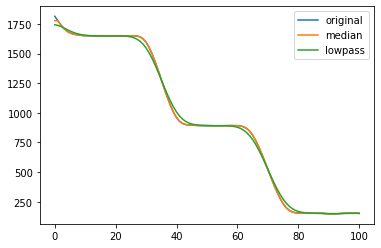

In [23]:
filt_person = median_filter(data_person[:,serie], 3)

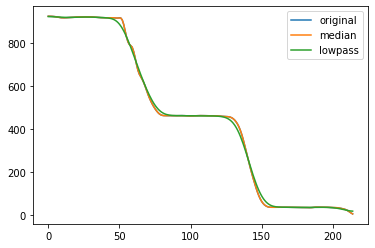

In [24]:
filt_patient = median_filter(f_patient, 5)

Una volta applicati i filtri per eliminare il rumore possiamo procedere con il calcolo delle derivate.

### Differenze finite
Calcoliamo la derivata prima dei segnali tramite il calcolo delle differenze finite. In matematica discreta le differenze finite sono definite come:

$f'(x) = \frac{f(x+h)-f(x)}{h}$

Il calcolo delle differenze finite ci permette di rilevare punti di cambiamento del segnale. Il parametro h può assumere valori discreti, come il nostro campionamento, e il valore più piccolo che può assumere è uguale all'ampiezza del periodo di campionamento (25 fps).


In [25]:
def derivative(f):
    h = 25
    f_prime = np.zeros(f.shape[0])
    for i in range(f.shape[0]-1):
        f_prime[i] = (-f[i+1] + f[i])/h
    
    return f_prime

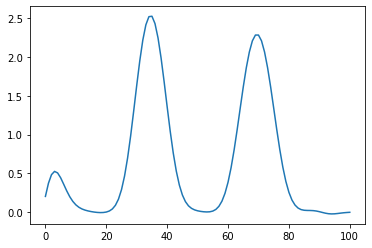

In [26]:
f_person_prime = derivative(filt_person)
plt.plot(f_person_prime)

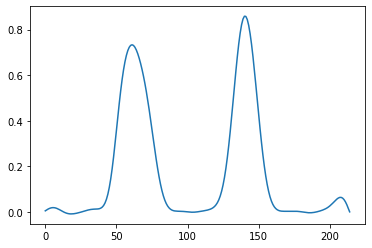

In [27]:
f_patient_prime = derivative(filt_patient)
plt.plot(f_patient_prime)

Una volta calcolate le derivate possiamo procedere con l'identificazione di porzioni di incremento, decremento e cambi di direzione (massimi e minimi)

### Rilevamento picchi e valli

Tramite l'uso della funzione di libreria find_peaks andiamo ad individuare i massimi della derivata dei segnali. Una volta trovati i picchi procediamo, tramite la funzione valleys, ad individuare i minimi della derivata.

In [28]:
def peaks(f):
    peaks, _ = find_peaks(f, height=0.3*np.nanmax(f), distance = 0.05*len(f))
    plt.plot(f)
    plt.plot(peaks, f[peaks], "x")
    plt.show()
    return peaks

In [29]:
def valleys(f, peaks):
    max_height = 0.1*np.nanmax(f)
    tol = 0.01
    valleys = []
    
    for p in peaks:
        set = False
        for i in range(p,1,-1):
            if (f[i]-f[i-1]<= tol and f[i]<max_height):
                valleys.append(i)
                set = True
                break
            
        if (not(set)):
            valleys.append(i-1)
            
        set = False        
        for i in range(p,len(f)-1):
            if (f[i]-f[i+1]<= tol and f[i]<max_height):
                valleys.append(i)
                set = True
                break
                
        if (not(set)):
            valleys.append(i+1)
    
    plt.plot(f)
    plt.plot(valleys, f[valleys], "x")
    plt.show()            
    return valleys

#### Persona sana

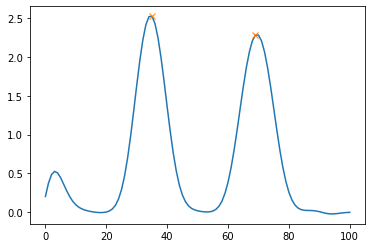

In [30]:
person_peaks= peaks(f_person_prime)

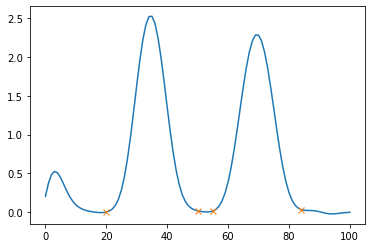

In [31]:
person_valleys= valleys(f_person_prime, person_peaks)

#### Paziente

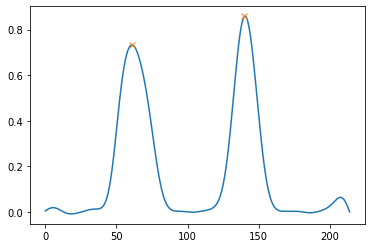

In [32]:
patient_peaks= peaks(f_patient_prime)

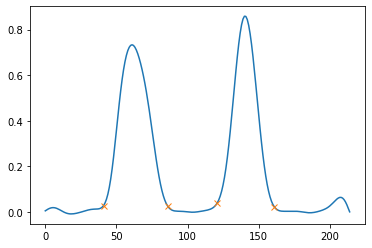

In [33]:
patient_valleys= valleys(f_patient_prime, patient_peaks)

### Statistiche
Il valore della derivata in un punto corrisponde alla velocità in quel punto. Ciò significa che le valli rappresentano il punto in cui il piede è fermo.

Queste informazioni ci permettono di calcolare delle statistiche sulla camminata del paziente e della persona sana: calcolando la distanza tra una valle e l'altra otteniamo il numero di frame necessari all'individuo per fare un passo. Sapendo che il campionamento del segnale è stato effettuato con una frequenza pari a 25 fps, possiamo ottenere il tempo impiegato per effettuare il passo.

In [34]:
def time(valleys):
    time = []
    for i in range(0,len(valleys)-1,2):
        time.append((valleys[i+1]-valleys[i])/25)
    return np.around(np.mean(time), 3)

In [35]:
print("Tempo medio impiegato dalla persona sana per effettuare un passo: ", time(person_valleys), "s")
print("Tempo medio impiegato dal paziente per effettuare un passo: ", time(patient_valleys), "s")

Tempo medio impiegato dalla persona sana per effettuare un passo:  1.18 s
Tempo medio impiegato dal paziente per effettuare un passo:  1.7 s


Analogamente possiamo analizzare la lunghezza del passo dei due individui

In [36]:
def length(f, valleys):
    length = []
    for i in range(0,len(valleys)-1,2):
        length.append((f[valleys[i]]-f[valleys[i+1]])/10)
    return np.around(np.mean(length), 3)

In [37]:
print("Lunghezza media di un passo della persona sana: ", length(filt_person, person_valleys), "cm")
print("Lunghezza media di un passo del paziente: ", length(filt_patient, patient_valleys), "cm")

Lunghezza media di un passo della persona sana:  74.709 cm
Lunghezza media di un passo del paziente:  43.747 cm


Possiamo ripetere il procedimento analizzando le statistiche per diversi individui e confrontare i risultati ottenuti.


Persona 0
- Filtraggio


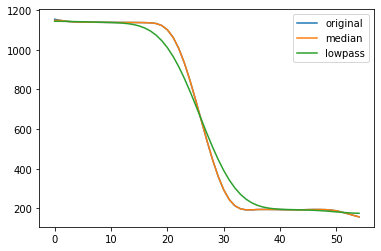

- Picchi


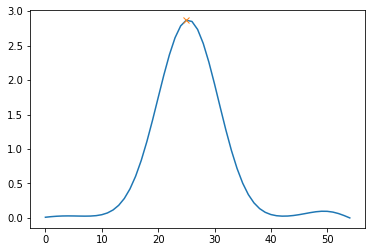

- Valli


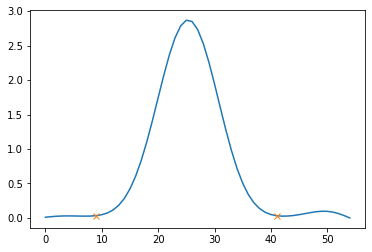


Persona 1
- Filtraggio


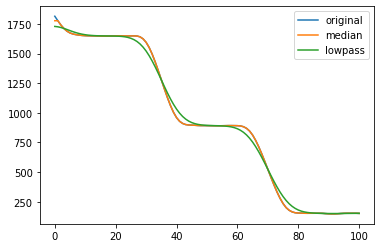

- Picchi


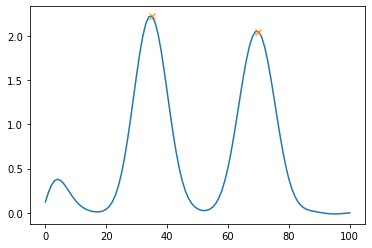

- Valli


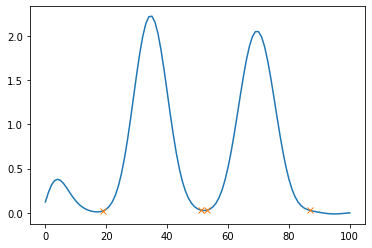


Persona 2
- Filtraggio


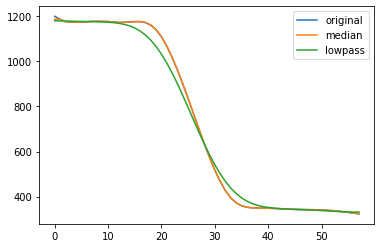

- Picchi


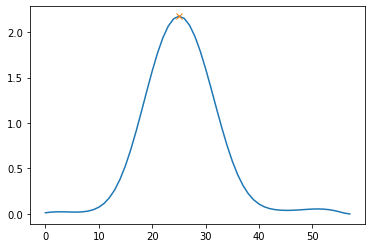

- Valli


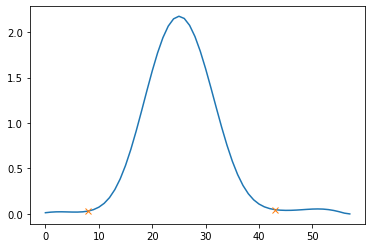


Persona 3
- Filtraggio


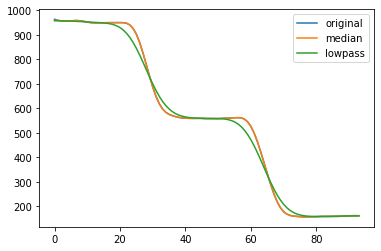

- Picchi


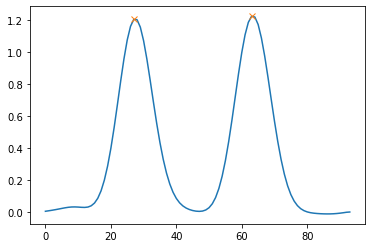

- Valli


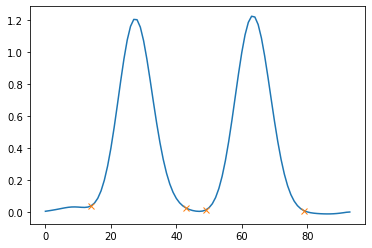


Persona 4
- Filtraggio


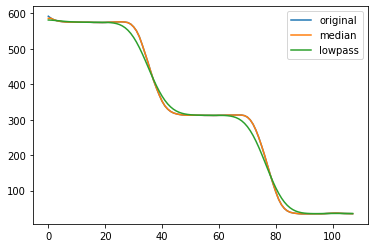

- Picchi


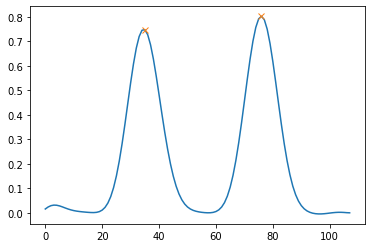

- Valli


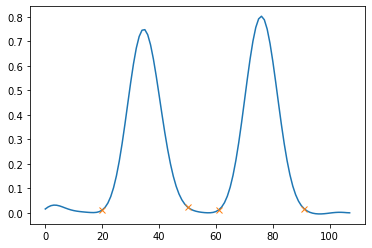

In [38]:
people_times = []
people_length = []
i=0

for person in data_people:
    print('\nPersona',i)
    f_person = removeNan(person[:, serie])
    print('- Filtraggio')
    filt_person = median_filter(f_person, 4)
    f_prime = derivative(filt_person)
    print('- Picchi')
    person_peaks = peaks(f_prime)
    print('- Valli')
    person_valleys = valleys(f_prime, person_peaks)
    people_times.append(time(person_valleys))
    people_length.append(length(filt_person, person_valleys))
    i+=1


Paziente 0
- Filtraggio


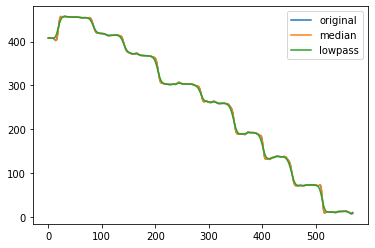

- Picchi


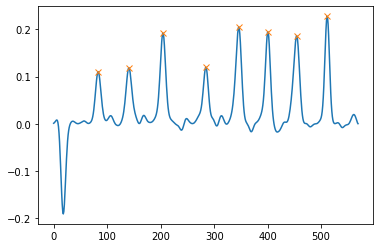

- Valli


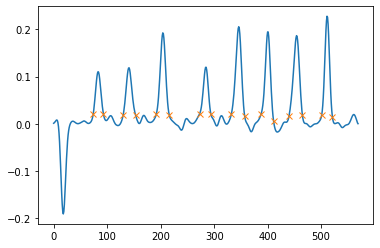


Paziente 1
- Filtraggio


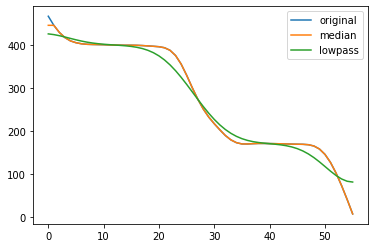

- Picchi


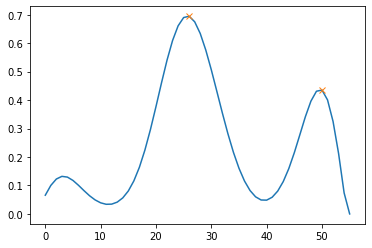

- Valli


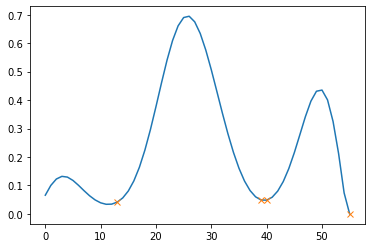


Paziente 2
- Filtraggio


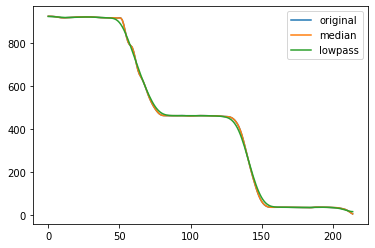

- Picchi


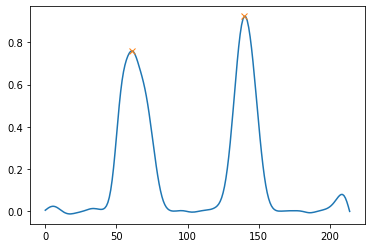

- Valli


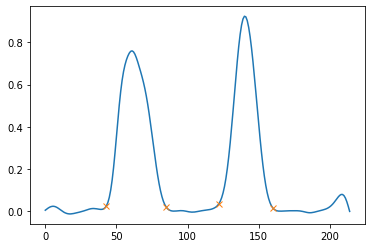


Paziente 3
- Filtraggio


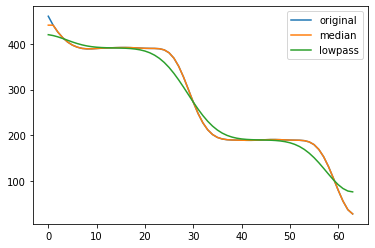

- Picchi


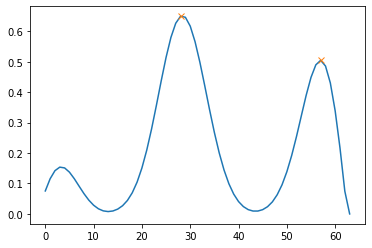

- Valli


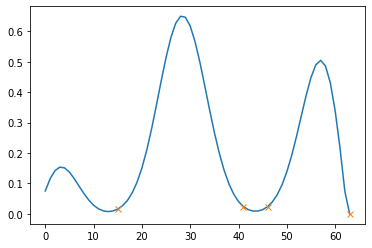


Paziente 4
- Filtraggio


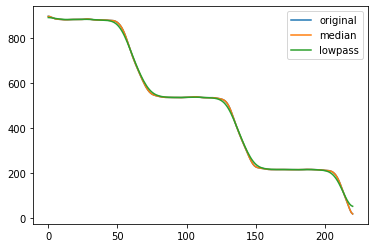

- Picchi


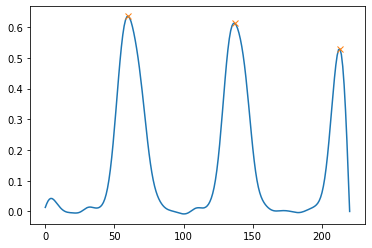

- Valli


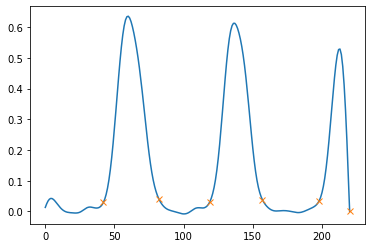


Paziente 5
- Filtraggio


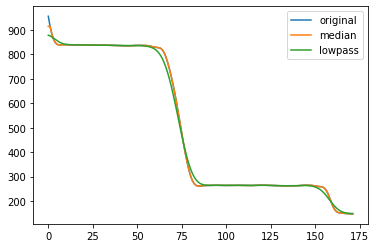

- Picchi


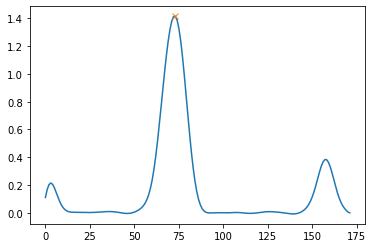

- Valli


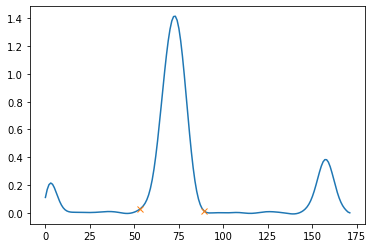


Paziente 6
- Filtraggio


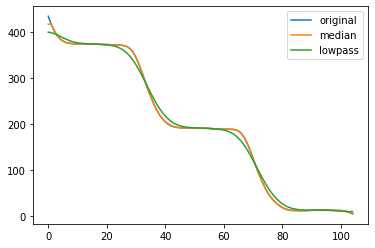

- Picchi


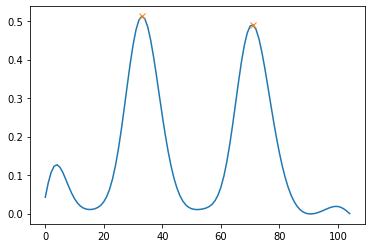

- Valli


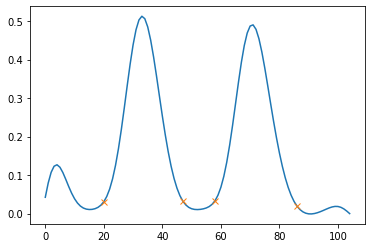

In [39]:
patients_times = []
patients_length = []
i=0
for patient in data_patients:
    print('\nPaziente',i)
    f_patient = removeNan(patient[:, serie])
    print('- Filtraggio')
    filt_patient = median_filter(f_patient, 4)
    f_prime = derivative(filt_patient)
    print('- Picchi')
    patient_peaks = peaks(f_prime)
    print('- Valli')
    patient_valleys = valleys(f_prime, patient_peaks)
    patients_times.append(time(patient_valleys))
    patients_length.append(length(filt_patient, patient_valleys))
    i+=1

Andiamo a stampare e confrontare i dati ottenuti, riguardanti il passo di pazienti e persone sane

In [42]:
print('Lunghezza passi persone sane', people_length)
print('Lungezza media passi persone sane', np.round(np.mean(people_length),2),'cm \n')

print('Lunghezza passi pazienti', patients_length)
print('Lunghezza media passi pazienti', np.round(np.mean(patients_length),2), 'cm \n')

print('Tempo passo persone sane', people_times)
print('Tempo medio passo persone sane', np.round(np.mean(people_times),2),'s \n')

print('Tempo passo pazienti', patients_times)
print('Tempo medio passo pazienti', np.round(np.mean(patients_times),2),'s \n')

Lunghezza passi persone sane [94.476, 74.758, 83.01, 39.419, 26.832]
Lungezza media passi persone sane 63.7 cm 

Lunghezza passi pazienti [5.266, 15.841, 43.804, 15.603, 27.19, 57.051, 17.659]
Lunghezza media passi pazienti 26.06 cm 

Tempo passo persone sane [1.28, 1.32, 1.4, 1.18, 1.2]
Tempo medio passo persone sane 1.28 s 

Tempo passo pazienti [0.9, 0.82, 1.6, 0.86, 1.333, 1.44, 1.1]
Tempo medio passo pazienti 1.15 s 



In [43]:
velocità_persone = np.round(np.divide(people_length,people_times),2)
print(velocità_persone)
print(np.round(np.mean(velocità_persone),2), "cm/s \n")

velocità_pazienti = np.round(np.divide(patients_length,patients_times),2)
print(velocità_pazienti)
print(np.round(np.mean(velocità_pazienti),2), "cm/s \n")

[73.81 56.63 59.29 33.41 22.36]
49.1 cm/s 

[ 5.85 19.32 27.38 18.14 20.4  39.62 16.05]
20.97 cm/s 



## Conclusioni